In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import numpy as np
import shapely.geometry as shpg
import os
import sys
import json
import logging

In [2]:
sys.path.append(os.getcwd() + '/../..')
from utils import mkdir, open_zip_shapefile, open_tar_shapefile, haversine

In [3]:
log = logging.getLogger('papermill')
logging.basicConfig(level='INFO', format="%(message)s")

## Files and storage paths

In [4]:
# Region of interest
reg = 19

# go down from rgi7_scripts/workflow
data_dir = '../../../../rgi7_data/'

# Input dirctory
input_dir_tar = os.path.join(data_dir, 'l4_rgi7b0_tar')
input_dir = os.path.join(data_dir, 'l4_rgi7b0')

### Load the input data

In [5]:
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions')
reg_file = gpd.read_file(reg_file)
fname = reg_file.loc[reg_file['o1region'] == f'{reg:02d}'].iloc[0]['long_code']

In [6]:
# Read beta files
shp = open_tar_shapefile(input_dir_tar + f'/RGI2000-v7.0-G-{fname}.tar.gz')
odf_subm = pd.read_csv(input_dir + f'/RGI2000-v7.0-G-{fname}/RGI2000-v7.0-G-{fname}_subm_info.csv', index_col=0)

VSIFSeekL(xxx, SEEK_END) may be really slow on GZip streams.


## Printouts for docs 

In [7]:
for i, line in odf_subm.iterrows():
    print(f"Submission {i}")
    print(f": **Submitter**: {line['submitters']} ({line['chief_affl']})."
          f"<br/>**Number of outlines**: {line['n_outlines']}. **Area**: {line['area_km2']:.1f}km². **Release date**: {line['release_dt'][:10]}."
          f"<br/>**Analysts**: {line['analysts']}.")
    print(f"")

Submission 585
: **Submitter**: Bliss, Andrew (University of Colorado).<br/>**Number of outlines**: 1794. **Area**: 98181.2km². **Release date**: 2015-07-01.<br/>**Analysts**: Berthier, Etienne; Bliss, Andrew; Cogley, Graham; LeBris, Raymond; Paul, Frank.

Submission 700
: **Submitter**: Hidalgo, Lidia Ferri (IANIGLA).<br/>**Number of outlines**: 31. **Area**: 242.8km². **Release date**: 2018-09-04.<br/>**Analysts**: Castro, Mariano; Gargantini, Hernán; Gimenez, Melisa; Hidalgo, Lidia Ferri; Masiokas, Mariano; Pecker Marcosig, Ivanna; Pitte, Pierre; Ruiz, Lucas; Zalazar, Laura.

Submission 769
: **Submitter**: Paul, Frank (OMP-LEGOS).<br/>**Number of outlines**: 340. **Area**: 536.8km². **Release date**: 2022-07-19.<br/>**Analysts**: Mabileau, Laure; Paul, Frank; Rastner, Philipp.

Submission 798
: **Submitter**: Berthier, Etienne (OMP-LEGOS).<br/>**Number of outlines**: 7. **Area**: 2684.6km². **Release date**: 2022-10-01.<br/>**Analysts**: Berthier, Etienne; Lebreton, Jerome.

Submis

In [8]:
odf_subm

,n_outlines,area_km2,anlys_time,release_dt,proc_desc,chief_affl,submitters,analysts,rc_id
subm_id,,,,,,,,,
585,1794,98181.177681,2014-12-01T00:00:00,2015-07-01T00:00:00,Mostly outlines from the Antarctic Digital Dat...,University of Colorado,"Bliss, Andrew","Berthier, Etienne; Bliss, Andrew; Cogley, Grah...",761
700,31,242.757545,2018-09-04T00:00:00,2018-09-04T09:00:00,Semi-automatic and manual glacier classificati...,IANIGLA,"Hidalgo, Lidia Ferri","Castro, Mariano; Gargantini, Hernán; Gimenez, ...",27
769,340,536.797111,2022-07-19T00:00:00,2022-07-19T09:00:00,Semi-automated glacier classification.; Semi-a...,OMP-LEGOS,"Paul, Frank","Mabileau, Laure; Paul, Frank; Rastner, Philipp",26
798,7,2684.574025,2022-10-01T00:00:00,2022-10-01T09:00:00,Manual glacier classification.; Manual mapping...,OMP-LEGOS,"Berthier, Etienne","Berthier, Etienne; Lebreton, Jerome",26
805,69,6529.673208,2022-10-01T00:00:00,2022-10-01T09:00:00,Manual glacier classification.; Mapping from L...,OMP-LEGOS,"McNabb, Robert","McNabb, Robert",26
806,23,2985.606566,2022-10-01T00:00:00,2022-10-01T09:00:00,Manual glacier classification.; Mapping from L...,OMP-LEGOS,"McNabb, Robert","McNabb, Robert",26
807,213,1656.691127,2022-11-01T00:00:00,2022-11-11T09:00:00,Mostly manual glacier classification.; 90% man...,OMP-LEGOS,"Kochtitzky, William","Cha, Leo; Gould, Luke; Kochtitzky, William; Me...",26
808,11,43.463106,2022-12-04T00:00:00,2022-12-15T09:00:00,"Mostly NDSI glacier classification, with manua...",OMP-LEGOS,"Kochtitzky, William","Kochtitzky, William",26
811,174,20568.255025,2022-10-01T00:00:00,2022-10-01T09:00:00,Manual glacier classification.; Mapping from L...,OMP-LEGOS,"McNabb, Robert","McNabb, Robert",26


## Maps 

In [9]:
import salem
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from matplotlib.image import imread
import seaborn as sns

In [10]:
rdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions', '00_rgi70_O1Regions.shp'))
srdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O2Regions', '00_rgi70_O2Regions.shp'))

rdf = rdf.loc[rdf['o1region'] == f'{reg:02d}']
srdf = srdf.loc[srdf['o1region'] == f'{reg:02d}']

In [11]:
extent = [rdf.min_x.iloc[0], rdf.max_x.iloc[0], rdf.min_y.iloc[0], rdf.max_y.iloc[0]]
extent

[-180.0, 180.0, -85.4877134800003, -45.5]

In [50]:
extent = [-180, 180, -90, -47]

In [51]:
map_crs = ccrs.SouthPolarStereo()

In [52]:
shp_repr = shp.to_crs(map_crs)

In [58]:
np.arange(9) * 45 - 180

array([-180, -135,  -90,  -45,    0,   45,   90,  135,  180])

N=1794, A=98181.2 km²
N=868, A=35247.8 km²


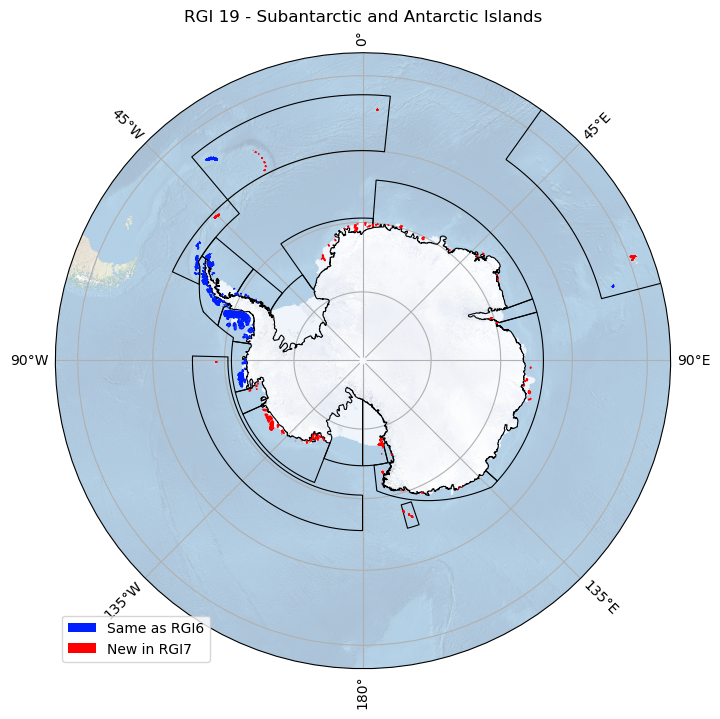

In [67]:
linewidth = 0.9
title = 'RGI 19 - Subantarctic and Antarctic Islands' 
is_rgi6 = True

import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=map_crs)
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add the following line:
ax.set_boundary(map_circle, transform=ax.transAxes)
# ax.coastlines();
# ax.gridlines();

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, dms=True, 
                  xlocs=np.arange(9) * 45 - 180);
# gl.top_labels = False
# gl.right_labels = False

# fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large4096px.png'
fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large8192px_white.png'
ax.imshow(imread(fname), origin='upper', transform=ccrs.PlateCarree(), 
          extent=[-180, 180, -90, 90])

# rdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=3, linewidth=1.5)
srdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=90, linewidth=0.8)

handles = []
if is_rgi6:
    for itis in [True, False]:
        ec = '#001fff' if itis else '#ff0000'
        fc = '#465dff' if itis else '#ff4646'
        label = 'Same as RGI6' if itis else 'New in RGI7'
        s_loc = shp_repr.loc[shp_repr['is_rgi6'] == itis]
        if len(s_loc) > 0:
            s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=linewidth, zorder=97)
            area = s_loc['area_km2'].sum()
        else:
            area = 0
        print(f'N={len(s_loc)}, A={area:.1f} km²')
        handles.append(mpatches.Patch(facecolor=ec, label=f'{label}'))
else:
    for i, subid in enumerate(sorted(shp.subm_id.unique().astype(int))):
        fc = f'C{i}'
        ec = fc
        s_loc = shp_repr.loc[shp.subm_id == subid]
        s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=linewidth, zorder=97)
        area = s_loc['area_km2'].sum()
        handles.append(mpatches.Patch(facecolor=fc, label=f'{subid}'))
        print(f'N={len(s_loc)}, A={area:.1f} km²')

# Alternative solution for "Polygon handles not passing to legend"
ax.legend(handles=handles, loc='lower left');
ax.set_title(title);

plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
mkdir(plot_dir)
plotname = 'isrgi6_map' if is_rgi6 else 'inventory_map'
plt.savefig(plot_dir + f'/{plotname}.jpeg', bbox_inches='tight', dpi=300)

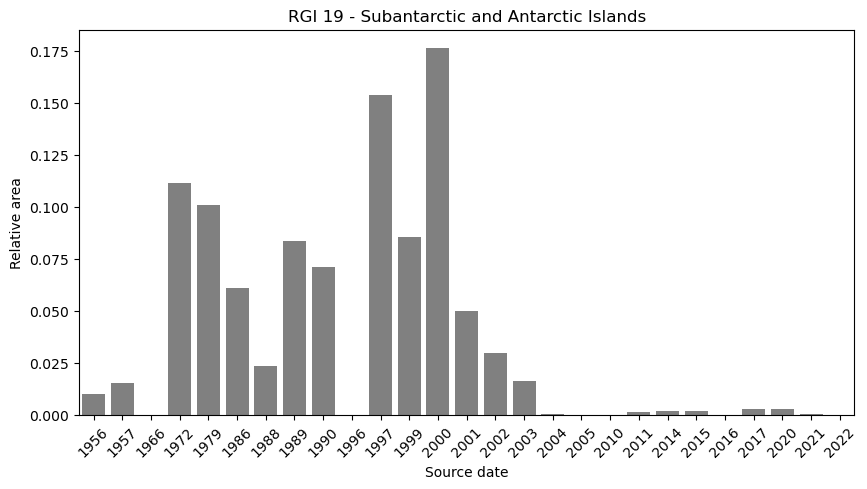

In [63]:
figsize=(10, 5)

f, ax = plt.subplots(figsize=figsize)

date = shp['src_date'].str[:4].astype(int).to_frame('src_date')
date['area'] = shp['area_km2']
date = date.groupby('src_date')['area'].sum().to_frame()
# if reset_index:
#     date = date.reindex(np.arange(date.index.min(), date.index.max()+1, dtype=int), fill_value=0)
date['area'] = date['area'] / date['area'].sum()
date = date.reset_index()

sns.barplot(ax=ax, x='src_date', y='area', data=date, color='grey');
ax.set_ylabel('Relative area'); ax.set_xlabel('Source date'); 
ax.set_title(title);
plt.xticks(rotation=45, ha='center')

plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
mkdir(plot_dir)
plotname = 'date_hist'
plt.savefig(plot_dir + f'/{plotname}.png', bbox_inches='tight', dpi=300)